<div>
     <div>
        <img src="./report/isel_logo.png" width="400" height="400" align="left">
    </div>
    <div>
        <h2>Área Departamental de Engenharia de Eletrónica e Telecomunicações e de Computadores</h2>
        <p>Trabalho prático 3</p>
        <p>Autor:	44598	André L. A. Q. de Oliveira</p>
        <p>Unidade Curricular Compressão de Sinais Multimédia</p>
        <p>Professor: André Lourenço</p>
        <p>11 - Junho - 2021</p>
    </div>
</div>

### <a id="index"></a>

# Index
- [Tabelas da norma ITU T.81 - JPEG standard](#ITU_T.81)
- [Compressão](#compressao)
    - [snr](#snr)
- [Utilities I/O](#io_utilities)
    - [bits_to_number](#bits_to_number)
    - [number_to_binary_list](#number_to_binary_list)
    - [string_to_binary_list](#string_to_binary_list)
    - [binary_list_to_string](#pad_bits)
    - [pad_bits](#binary_list_to_string)
    - [InputBitReader](#input_bit_reader)
- [JPEG - Baseline](#jpeg_baseline)
    - [JPEG Utilities](#jpeg_utilities)
        - [Espaço de cor JPEG](#yuv)
        - [rgb2yuv](#rgb2yuv)
        - [yuv2rgb](#yuv2rgb)
        - [block_to_zigzag](#block_to_zigzag)
        - [zigzag_to_block](#zigzag_to_block)
        - [quality_factor](#quality_factor)
        - [get_bits_complement](#get_bits_complement)
        - [get_size](#get_size)
        - [get_amplitude_from_number](#get_amplitude_from_number)
        - [get_number_from_amplitude](#get_number_from_amplitude)
        - [nearest_multiple](#nearest_multiple)
        - [divide_to_blocks](#divide_to_blocks)
        - [merge_from_blocks](#merge_from_blocks)
    - [DCT](#dct)
        - [dct](#dct_encode)
        - [idct](#dct_decode)
    - [Quantificação](#quantificacao)
        - [quantific_encode](#quantific_encode)
        - [quantific_decode](#quantific_decode)
    - [DPCM](#dpcm)
        - [dpcm_encode](#dpcm_encode)
        - [dpcm_decode](#dpcm_decode)
    - [RLC](#rlc)
        - [rlc_encode](#rlc_encode)
        - [rlc_decode](#rlc_decode)
    -[JPEG Enconding / Decoding](#jpeg_encoding_decoding)
        - [jpeg_encoder](#jpeg_encoder)
        - [jpeg_decoder](#jpeg_decoder)
- [I/O](#io)
    - [Escrever para ficheiro](#escrever_ficheiro)
        - [write_to_file](#write_to_file)
    - [Ler ficheiro](#ler_ficheiro)
        - [get_dc](#get_dc)
        - [get_ac](#get_ac)
        - [read_from_file](#read_from_file)
- [Testes](#testes)
    - [Lena Grayscale](#lena_grayscale)
    - [Gráfico](#grafico)
    - [Tabelas](#tabelas)
- [Conclusões](#conclusoes)

# Importar bibliotecas

In [1]:
import os
from time import time
import cv2
import numpy as np
import matplotlib.pyplot as plt

cwd = os.getcwd() # current work diretory

# Importar dados

<a id="ITU_T.81"></a>

# Tabelas da norma ITU T.81 - JPEG standard

In [2]:
lena_gray = cv2.imread(f"{cwd}/input_data/lena.tif", cv2.IMREAD_GRAYSCALE)
lena_color = cv2.imread(f"{cwd}/input_data/lena.tif")

lena_block_1 = lena_gray[0:8,0:8]
lena_block_2 = lena_gray[0:8,8:16]
lena_block_3 = lena_gray[0:8,16:24]

In [3]:
# tabela K1 - Luminance quantize Matrix  
K1 = np.zeros((8, 8))
K1[0] = [ 16,  11,  10,  16,  24,  40,  51,  61]
K1[1] = [ 12,  12,  14,  19,  26,  58,  60,  55]
K1[2] = [ 14,  13,  16,  24,  40,  57,  69,  56]
K1[3] = [ 14,  17,  22,  29,  51,  87,  80,  62]
K1[4] = [ 18,  22,  37,  56,  68, 109, 103,  77]
K1[5] = [ 24,  35,  55,  64,  81, 104, 113,  92]
K1[6] = [ 49,  64,  78,  87, 103, 121, 120, 101]
K1[7] = [ 72,  92,  95,  98, 112, 100, 103,  99]

# Tabela K3 
# Table for luminance DC coefficient differences
K3 = dict()
K3[0]  = "00"
K3[1]  = "010"
K3[2]  = "011"
K3[3]  = "100"
K3[4]  = "101"
K3[5]  = "110"
K3[6]  = "1110"
K3[7]  = "11110"
K3[8]  = "111110"
K3[9]  = "1111110"
K3[10] = "11111110"
K3[11] = "111111110"

# Tabela iK3 
# Inverted Table for luminance DC coefficient differences
iK3 = dict(map(reversed, K3.items()))

# Tabela K5 
# Table for luminance AC coefficients
K5 = dict()
K5[(0, 0)] = "1010"
K5[(0, 1)] = "00"
K5[(0, 2)] = "01"
K5[(0, 3)] = "100"
K5[(0, 4)] = "1011"
K5[(0, 5)] = "11010"
K5[(0, 6)] = "1111000"
K5[(0, 7)] = "11111000"
K5[(0, 8)] = "1111110110"
K5[(0, 9)] = "1111111110000010"
K5[(0,10)] = "1111111110000011"

K5[(1, 1)] = "1100"
K5[(1, 2)] = "11011"
K5[(1, 3)] = "1111001"
K5[(1, 4)] = "111110110"
K5[(1, 5)] = "11111110110"
K5[(1, 6)] = "1111111110000100"
K5[(1, 7)] = "1111111110000101"
K5[(1, 8)] = "1111111110000110"
K5[(1, 9)] = "1111111110000111"
K5[(1,10)] = "1111111110001000"

K5[(2, 1)] = "11100"
K5[(2, 2)] = "11111001"
K5[(2, 3)] = "1111110111"
K5[(2, 4)] = "111111110100"
K5[(2, 5)] = "1111111110001001"
K5[(2, 6)] = "1111111110001010"
K5[(2, 7)] = "1111111110001011"
K5[(2, 8)] = "1111111110001100"
K5[(2, 9)] = "1111111110001101"
K5[(2,10)] = "1111111110001110"

K5[(3, 1)] = "111010"
K5[(3, 2)] = "111110111"
K5[(3, 3)] = "111111110101"
K5[(3, 4)] = "1111111110001111"
K5[(3, 5)] = "1111111110010000"
K5[(3, 6)] = "1111111110010001"
K5[(3, 7)] = "1111111110010010"
K5[(3, 8)] = "1111111110010011"
K5[(3, 9)] = "1111111110010100"
K5[(3,10)] = "1111111110010101"

K5[(4, 1)] = "111011"
K5[(4, 2)] = "1111111000"
K5[(4, 3)] = "1111111110010110"
K5[(4, 4)] = "1111111110010111"
K5[(4, 5)] = "1111111110011000"
K5[(4, 6)] = "1111111110011001"
K5[(4, 7)] = "1111111110011010"
K5[(4, 8)] = "1111111110011011"
K5[(4, 9)] = "1111111110011100"
K5[(4,10)] = "1111111110011101"

K5[(5, 1)] = "1111010"
K5[(5, 2)] = "11111110111"
K5[(5, 3)] = "1111111110011110"
K5[(5, 4)] = "1111111110011111"
K5[(5, 5)] = "1111111110100000"
K5[(5, 6)] = "1111111110100001"
K5[(5, 7)] = "1111111110100010"
K5[(5, 8)] = "1111111110100011"
K5[(5, 9)] = "1111111110100100"
K5[(5,10)] = "1111111110100101"

K5[(6, 1)] = "1111011"
K5[(6, 2)] = "111111110110"
K5[(6, 3)] = "1111111110100110"
K5[(6, 4)] = "1111111110100111"
K5[(6, 5)] = "1111111110101000"
K5[(6, 6)] = "1111111110101001"
K5[(6, 7)] = "1111111110101010"
K5[(6, 8)] = "1111111110101011"
K5[(6, 9)] = "1111111110101100"
K5[(6,10)] = "1111111110101101"

K5[(7, 1)] = "11111010"
K5[(7, 2)] = "111111110111"
K5[(7, 3)] = "1111111110101110"
K5[(7, 4)] = "1111111110101111"
K5[(7, 5)] = "1111111110110000"
K5[(7, 6)] = "1111111110110001"
K5[(7, 7)] = "1111111110110010"
K5[(7, 8)] = "1111111110110011"
K5[(7, 9)] = "1111111110110100"
K5[(7,10)] = "1111111110110101"

K5[(8, 1)] = "111111000"
K5[(8, 2)] = "111111111000000"
K5[(8, 3)] = "1111111110110110"
K5[(8, 4)] = "1111111110110111"
K5[(8, 5)] = "1111111110111000"
K5[(8, 6)] = "1111111110111001"
K5[(8, 7)] = "1111111110111010"
K5[(8, 8)] = "1111111110111011"
K5[(8, 9)] = "1111111110111100"
K5[(8,10)] = "1111111110111101"

K5[(9, 1)] = "111111001"
K5[(9, 2)] = "1111111110111110"
K5[(9, 3)] = "1111111110111111"
K5[(9, 4)] = "1111111111000000"
K5[(9, 5)] = "1111111111000001"
K5[(9, 6)] = "1111111111000010"
K5[(9, 7)] = "1111111111000011"
K5[(9, 8)] = "1111111111000100"
K5[(9, 9)] = "1111111111000101"
K5[(9,10)] = "1111111111000110"

K5[(10, 1)] = "111111010"
K5[(10, 2)] = "1111111111000111"
K5[(10, 3)] = "1111111111001000"
K5[(10, 4)] = "1111111111001001"
K5[(10, 5)] = "1111111111001010"
K5[(10, 6)] = "1111111111001011"
K5[(10, 7)] = "1111111111001100"
K5[(10, 8)] = "1111111111001101"
K5[(10, 9)] = "1111111111001110"
K5[(10,10)] = "1111111111001111"

K5[(11, 1)] = "1111111001"
K5[(11, 2)] = "1111111111010000"
K5[(11, 3)] = "1111111111010001"
K5[(11, 4)] = "1111111111010010"
K5[(11, 5)] = "1111111111010011"
K5[(11, 6)] = "1111111111010100"
K5[(11, 7)] = "1111111111010101"
K5[(11, 8)] = "1111111111010110"
K5[(11, 9)] = "1111111111010111"
K5[(11,10)] = "1111111111011000"

K5[(12, 1)] = "1111111010"
K5[(12, 2)] = "1111111111011001"
K5[(12, 3)] = "1111111111011010"
K5[(12, 4)] = "1111111111011011"
K5[(12, 5)] = "1111111111011100"
K5[(12, 6)] = "1111111111011101"
K5[(12, 7)] = "1111111111011110"
K5[(12, 8)] = "1111111111011111"
K5[(12, 9)] = "1111111111100000"
K5[(12,10)] = "1111111111100001"

K5[(13, 1)] = "11111111000"
K5[(13, 2)] = "1111111111100010"
K5[(13, 3)] = "1111111111100011"
K5[(13, 4)] = "1111111111100100"
K5[(13, 5)] = "1111111111100101"
K5[(13, 6)] = "1111111111100110"
K5[(13, 7)] = "1111111111100111"
K5[(13, 8)] = "1111111111101000"
K5[(13, 9)] = "1111111111101001"
K5[(13,10)] = "1111111111101010"

K5[(14, 1)] = "1111111111101011"
K5[(14, 2)] = "1111111111101100"
K5[(14, 3)] = "1111111111101101"
K5[(14, 4)] = "1111111111101110"
K5[(14, 5)] = "1111111111101111"
K5[(14, 6)] = "1111111111110000"
K5[(14, 7)] = "1111111111110001"
K5[(14, 8)] = "1111111111110010"
K5[(14, 9)] = "1111111111110011"
K5[(14,10)] = "1111111111110100"

K5[(15, 0)] = "11111111001"
K5[(15, 1)] = "1111111111110101"
K5[(15, 2)] = "1111111111110110"
K5[(15, 3)] = "1111111111110111"
K5[(15, 4)] = "1111111111111000"
K5[(15, 5)] = "1111111111111001"
K5[(15, 6)] = "1111111111111010"
K5[(15, 7)] = "1111111111111011"
K5[(15, 8)] = "1111111111111100"
K5[(15, 9)] = "1111111111111101"
K5[(15,10)] = "1111111111111110"

# Tabela iK5 
# Inverted Table for luminance AC coefficients
iK5 = dict(map(reversed, K5.items()))

# ordem zig-zag 
zigzag = np.zeros((8, 8))
zigzag[0] = [ 0,  1,  5,  6, 14, 15, 27, 28]
zigzag[1] = [ 2,  4,  7, 13, 16, 26, 29, 42]
zigzag[2] = [ 3,  8, 12, 17, 25, 30, 41, 43]
zigzag[3] = [ 9, 11, 18, 24, 31, 40, 44, 53]
zigzag[4] = [10, 19, 23, 32, 39, 45, 52, 54]
zigzag[5] = [20, 22, 33, 38, 46, 51, 55, 60]
zigzag[6] = [21, 34, 37, 47, 50, 56, 59, 61]
zigzag[7] = [35, 36, 48, 49, 57, 58, 62, 63]
ind_zz = zigzag.reshape((64),order='F').astype('int16')
ind_zz_r = zigzag.reshape((64)).astype('int16')

ind_zz_index = np.argsort(ind_zz)

[back to index](#index)

<a id="compressao"></a>

# Compressão

A taxa de compressão pode ser cáculada atrás da seguinte expressão matemática:

$$ T_c = \frac{D_o}{D_c} $$

<a id="snr"></a>

## snr

A relação sinal-ruído compara o nível de um sinal desejado com o nível do ruído. Quanto mais alta for a relação sinal-ruído, menor é o efeito do ruído de fundo sobre a detecção ou medição do sinal.

$$ SNR(Db) = 10\log_{10}\left[\frac{\sum_{l}\sum_{c}I_{ap}(l,c)^2}{\sum_{l}\sum_{c}[I_{ap}(l,c)-I_{or}(l,c)]^2}\right] $$

In [4]:
def snr(I_or, I_ap):
    Pxa = np.sum(I_ap.astype('float')**2)
    Pe = np.sum( (I_ap.astype('float') - I_or.astype('float'))**2 )
    return 10 * np.log10(Pxa / Pe)

[back to index](#index)

<a id="io_utilities"></a>

# I/O Utilities

<a id="bits_to_number"></a>

## bits_to_number

Converte uma string the bits para um número inteiro.

In [5]:
def bits_to_number(bits):
    return int(bits, 2)

<a id="number_to_binary_list"></a>

## number_to_binary_list

Converte um número inteiro na menor sequência de bits que o representa.

In [6]:
def number_to_binary_list(n):
    # convert integer into a list of bits
    return [n] if (n <= 1) else number_to_binary_list(n >> 1) + [n & 1]

<a id="string_to_binary_list"></a>

## string_to_binary_list

Converte uma string de bits para uma lista binária.

In [7]:
def string_to_binary_list(message):    
    return list(map(int, message))

<a id="binary_list_to_string"></a>

## binary_list_to_string

Converte uma lista binária para uma string de bits.

In [8]:
def binary_list_to_string(arr):
    return ''.join(list(map(str,arr)))

<a id="pad_bits"></a>

## pad_bits

Extende o número de zeros a uma sequência de bits, para permitir codificação de tamanho fixo. Os zeros são adicionados nas posições de bit mais significantes

In [9]:
def pad_bits(bits, n):
    # prefix string of bits with enough zeros to reach n digits
    if isinstance(bits, np.ndarray):
        if(n - len(bits) > 0):
            return np.pad(bits, (n - len(bits), 0))
        else:
            return bits
    else:
        return ([0] * (n - len(bits)) + bits)

<a id="input_bit_reader"></a>

## InputBitReader

Para realizar compressão e descompressão com eficácia, é necessesário manipular os fluxos de dados como um fluxo de bits individuais.

A classe InputBitReader permite uma fácil leitura de de uma sequência de bits bit a bit.
* **read_bit:** retorna o próximo bit
* **read_bits(n):** retorna os próximos **n** bits
* **read_byte(n):** retorna o próximo byte
* **has_next**: indica se ainda existem bits da sequência que não foram lidos

In [10]:
class InputBitReader(object): 
    def __init__(self, bit_seq): 
        self.bit_seq = bit_seq
        self.size = len(bit_seq)
        self.bits_read = 0
        self.buffer = []

    def read_bit(self):
        if self.bits_read < self.size:
            return self.read_bits(1)[0]
        else:
            return None

    def read_bits(self, n):
        self.__flush()
        if self.bits_read < self.size:
            self.buffer = self.bit_seq[self.bits_read:(self.bits_read + n)]
            self.bits_read += n
        return self.buffer
    
    def read_byte(self):
        if self.bits_read < self.size:
            byte = ''.join(list(map(str, self.read_bits(8))))
            return int(byte, 2)
        else:
            return None
        
    def has_next(self):
        return (self.size - self.bits_read) > 0

    def __flush(self):
        self.buffer = []

[back to index](#index)

<a id="jpeg_baseline"></a>

# JPEG - Baseline

A compressão Baseline JPEG utiliza um algoritmo de compressão JPEG que começará a exibir a imagem conforme os dados são disponibilizados, linha por linha. 

Num browser, as imagens JPEG seriam exibidas sequêncialmente, linha a linha, como demonstra a imagem seguinte.

![Baseline-Example](./report/Baseline-Example.jpg)

<a id="yuv"></a>

### Espaço de cor JPEG

A grande maioria das implementações do algorítmo JPEG usam luminância e crominância (codificação YUV) em vez de RGB. Como olho humano não conseguir destinguir mudanças de brilho de alta frequência numa área pequena, é possível então reduzir a quantidade de frequência de uma imagem, resultando em uma imagem altamente compactada com quase nenhuma redução visível na qualidade.

Assim como cada pixel no espaço de cores RGB é composto de 3 bytes de dados de cores (vermelho, verde, azul), cada pixel em YUV também usa 3 bytes, mas o que cada byte representa é ligeiramente diferente. O componente Y determina o brilho da cor (luminância), enquanto os componentes U e V determinam a cor (crominância). O componente U refere-se à quantidade da cor azul e o componente V refere-se à quantidade da cor vermelha.

<a id="rgb2yuv"></a>

### rgb2yuv

Converte uma imagem do espaço de cores RGB para YUV.

In [11]:
def rgb2yuv(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)

<a id="yuv2rgb"></a>

### yuv2rgb

Converte uma imagem do espaço de cores UYV para RGB.

In [12]:
def yuv2rgb(image):
    return cv2.cvtColor(image, cv2.COLOR_YUV2RGB) 

[back to index](#index)

<a id="block_to_zigzag"></a>

### block_to_zigzag

Converte um block de 8x8 para um array com uma ordenação zigzag.

In [13]:
def block_to_zigzag(block, ind_zz_index):
    output = block.reshape((64),order='F').astype('int16')
    return output[ind_zz_index]

<a id="zigzag_to_block"></a>

### zigzag_to_block

Converte um array com uma ordenação zigzag para um block de 8x8.

In [14]:
def zigzag_to_block(zigzag, ind_zz_r):
    output = zigzag[ind_zz_r]
    return output.reshape((8,8),order='C').astype('int16')

In [15]:
arr1 = np.arange(64).reshape((8,8))
print("block\n", arr1, "\n")
arr2 = block_to_zigzag(arr1, ind_zz_index)
print("block to zigzag\n", arr2,"\n")
arr3 = zigzag_to_block(arr2, ind_zz_r)
print("zigzag to block\n", arr3,"\n")

block
 [[ 0  1  2  3  4  5  6  7]
 [ 8  9 10 11 12 13 14 15]
 [16 17 18 19 20 21 22 23]
 [24 25 26 27 28 29 30 31]
 [32 33 34 35 36 37 38 39]
 [40 41 42 43 44 45 46 47]
 [48 49 50 51 52 53 54 55]
 [56 57 58 59 60 61 62 63]] 

block to zigzag
 [ 0  1  8 16  9  2  3 10 17 24 32 25 18 11  4  5 12 19 26 33 40 48 41 34
 27 20 13  6  7 14 21 28 35 42 49 56 57 50 43 36 29 22 15 23 30 37 44 51
 58 59 52 45 38 31 39 46 53 60 61 54 47 55 62 63] 

zigzag to block
 [[ 0  1  2  3  4  5  6  7]
 [ 8  9 10 11 12 13 14 15]
 [16 17 18 19 20 21 22 23]
 [24 25 26 27 28 29 30 31]
 [32 33 34 35 36 37 38 39]
 [40 41 42 43 44 45 46 47]
 [48 49 50 51 52 53 54 55]
 [56 57 58 59 60 61 62 63]] 



[back to index](#index)

<a id="quality_factor"></a>

### quality_factor

Função para calcular o valor a multiplicar  a tabela K1 a partir do fator de qualidade.

In [16]:
def quality_factor(q):
    if(q <= 50):
        factor = 50.0 / q
    else:
        factor = 2.0 - (q * 2.0)/100.0
    return factor 

In [17]:
print(f"quality_factor({1}):   {quality_factor(1)}")
for q in range(10, 100, 10):
    print(f"quality_factor({q}):  {round(quality_factor(q), 1)}")
print(f"quality_factor({100}): {quality_factor(100)}")

quality_factor(1):   50.0
quality_factor(10):  5.0
quality_factor(20):  2.5
quality_factor(30):  1.7
quality_factor(40):  1.2
quality_factor(50):  1.0
quality_factor(60):  0.8
quality_factor(70):  0.6
quality_factor(80):  0.4
quality_factor(90):  0.2
quality_factor(100): 0.0


[back to index](#index)

<a id="get_size"></a>

### get_size

Função que conta o número de bits necessário para armazenar um número.

In [18]:
def get_size(number):
    if number == 0:
        return 0
    if number >= -1 and number <= 1:
        return 1
    if number >= -3 and number <= 3:
        return 2
    if number >= -7 and number <= 7:
        return 3
    if number >= -15 and number <= 15:
        return 4
    if number >= -31 and number <= 31:
        return 5
    if number >= -63 and number <= 63:
        return 6
    if number >= -127 and number <= 127:
        return 7
    if number >= -255 and number <= 255:
        return 8
    if number >= -511 and number <= 511:
        return 9
    if number >= -1023 and number <= 1023:
        return 10

In [19]:
print(f"get_size(80) -> {get_size(80)}")
print(f"get_size(3)  -> {get_size(3)}")
print(f"get_size(0)  -> {get_size(0)}")

get_size(80) -> 7
get_size(3)  -> 2
get_size(0)  -> 0


<a id="get_bits_complement"></a>

### get_bits_complement

Realizada o complemento de 1 para uma string de números binários.

In [20]:
def get_bits_complement(bit_string):
    return bit_string.replace('1','2').replace('0','1').replace('2','0')

<a id="get_amplitude_from_number"></a>

### get_amplitude_from_number

Converte um número inteiro para amplitude.

In [21]:
def get_amplitude_from_number(number):
    if number == 0:
        return None
    elif number < 0:
        bits = "{0:b}".format(-1 * number)
        return get_bits_complement(bits)
    else:
        return "{0:b}".format(number)

In [22]:
print("get_amplitude_from_number(80) -> ", get_amplitude_from_number(80))
print("get_amplitude_from_number(0)  -> ", get_amplitude_from_number(0))
print("get_amplitude_from_number(-1) -> ", get_amplitude_from_number(-1))
print("get_amplitude_from_number(-2) -> ", get_amplitude_from_number(-2))
print("get_amplitude_from_number(-3) -> ", get_amplitude_from_number(-3))

get_amplitude_from_number(80) ->  1010000
get_amplitude_from_number(0)  ->  None
get_amplitude_from_number(-1) ->  0
get_amplitude_from_number(-2) ->  01
get_amplitude_from_number(-3) ->  00


<a id="get_number_from_amplitude"></a>

### get_number_from_amplitude

Converte amplitude para um número inteiro.

In [23]:
def get_number_from_amplitude(amplitude):
    if amplitude[0] == "0":
        return -1 * int(get_bits_complement(amplitude), 2) 
    else:
        return int(amplitude, 2)

In [24]:
print("get_number_from_amplitude(1010000) -> ", get_number_from_amplitude('1010000'))
print("get_number_from_amplitude('0')     -> ", get_number_from_amplitude('0'))
print("get_number_from_amplitude('01')    -> ", get_number_from_amplitude('01'))
print("get_number_from_amplitude('00')    -> ", get_number_from_amplitude('00'))

get_number_from_amplitude(1010000) ->  80
get_number_from_amplitude('0')     ->  -1
get_number_from_amplitude('01')    ->  -2
get_number_from_amplitude('00')    ->  -3


[back to index](#index)

<a id="nearest_multiple"></a>

### nearest_multiple

Retorna o múltiplo **base** mais próximo do número **number**.

In [25]:
def nearest_multiple(number,base):
    return ( base * round(number / base) )

<a id="divide_to_blocks"></a>

### divide_to_blocks

Divide uma imagem em array de blocos de tamnho size x size.

In [26]:
def divide_to_blocks(image, size):
    output = []
    
    if len(image.shape) < 3: 
        width, height = image.shape
        for lin in range(0, width, size):
            for col in range(0, height, size):
                img_w = lin + size
                img_h = col + size
                blc_w = size
                blc_h = size
                # check for out of bounds
                if (lin + size) > width:
                    img_w = width
                    blc_w = width - lin
                if (col + size) > height:
                    img_h = height
                    blc_h = height - col
                # create new block
                block = np.zeros(size*size, dtype='int16').reshape((size,size))
                block[0:blc_w,0:blc_h] = image[lin:img_w,col:img_h]
                output.append(block)
    else:
        width, height, band = image.shape
        for bnd in range(0, band):
            for lin in range(0, width, size):
                for col in range(0, height, size):
                    img_w = lin + size
                    img_h = col + size
                    blc_w = size
                    blc_h = size
                    # check for out of bounds
                    if (lin + size) > width:
                        img_w = width
                        blc_w = width - lin
                    if (col + size) > height:
                        img_h = height
                        blc_h = height - col
                    # create new block
                    block = np.zeros(size*size, dtype='int16').reshape((size,size))
                    block[0:blc_w,0:blc_h] = image[lin:img_w,col:img_h,bnd]
                    output.append(block)
                
    return output, image.shape

In [27]:
lena_gray_blocks, lena_gray_shape  = divide_to_blocks(lena_gray, 8)
lena_color_blocks, lena_color_shape = divide_to_blocks(lena_color, 8)

In [28]:
print("number of blocks for lena gray: ", len(lena_gray_blocks))
print("number of blocks for lena color:", len(lena_color_blocks))

number of blocks for lena gray:  4096
number of blocks for lena color: 12288


<a id="merge_from_blocks"></a>

### merge_from_blocks

Merge um array de blocos para uma imagem.

In [29]:
def merge_from_blocks(arr, shape, size):
    width = nearest_multiple(shape[0], size)
    heigth = nearest_multiple(shape[1], size)
    index = 0
    if len(shape) < 3:
        output = np.zeros((width, heigth), dtype='uint8')
        for lin in range(0, width, size):
            for col in range(0, heigth, size):
                output[lin:(lin+size),col:(col+size)] = arr[index]
                index = index + 1
        return output[0:shape[0],0:shape[1]]
    else:
        output = np.zeros((width, heigth, shape[2]), dtype='uint8')
        for bnd in range(0, shape[2]):
            for lin in range(0, width, size):
                for col in range(0, heigth, size):
                    output[lin:(lin+size),col:(col+size),bnd] = arr[index]
                    index = index + 1
        return output[0:shape[0],0:shape[1],:]

In [30]:
re_lena_gray = merge_from_blocks(lena_gray_blocks, lena_gray_shape, 8)
re_lena_color = merge_from_blocks(lena_color_blocks, lena_color_shape, 8)

In [31]:
#cv2.imshow("re_lena_gray", re_lena_gray)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

#cv2.imshow("re_lena_gray", re_lena_color)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

[back to index](#index)

<a id="dct"></a>

# DCT

Uma Transformação Discreta de Cosseno (DCT) é um método para converter pontos discretos numa combinação de ondas de cosseno, com o objetivo de encontrar pequenos componentes de alta frequência para depois serem descartados.

Na compressão em JPEG, o DCT encoder recebe um bloco de imagem 8x8 e para cada pixel é aplicado uma função de coseno. Para aplicar esta função utiliza-se uma matriz 8x8 de funções de coseno como demosntra a imagem seguinte.

![jpeg-encoding](./report/cosine-funcs.png)

Como resultado obtêm-se uma matriz de coeficientes DCT, que geralmente contém os valores maiores no canto superior esquerdo da matriz de coeficientes e valores menores no canto inferior direito. O canto superior esquerdo representa a função cosseno de frequência mais baixa e o canto inferior direito representa a função cosseno de frequência mais alta.

A maioria das imagens contém uma grande quantidade de informação de baixa frequência e uma pequena quantidade de informação de alta frequência. Ao remover os componentes do canto inferior direito de cada matriz DCT para 0, a imagem resultante ainda pareceria a mesma.

A razão pelo qual se descarta a informação de alta freqûencia deve-se ao facto de que o ser humano não consegue observar com clareza mudanças de alta frequência.

<a id="dct_encode"></a>

### DCT Encoder

Função que aplica uma transformação DCT sobre um bloco.

In [32]:
def dct(block):
    return cv2.dct(np.float32(block)).astype('int16') # float -> int16 conversion 

In [33]:
block_dct = []
for i in range(len(lena_gray_blocks)):
    block_dct.append(dct(lena_gray_blocks[i]))

In [34]:
re_from_dct = merge_from_blocks(block_dct, lena_gray_shape, 8)
cv2.imshow("DCT", re_from_dct)
cv2.waitKey(0)
cv2.destroyAllWindows()

<a id="dct_decoder"></a>

### DCT Decoder

Função que aplica uma transformação inversa da DCT sobre um bloco.

In [35]:
def idct(block):
    return cv2.idct(np.float32(block)).astype('int16') # float conversion -> int16 conversion

In [36]:
block_idct = []
for i in range(len(block_dct)):
    block_idct.append(idct(block_dct[i]))

In [37]:
re_from_idct = merge_from_blocks(block_idct, lena_gray_shape, 8)
cv2.imshow("IDCT", re_from_idct)
cv2.waitKey(0)
cv2.destroyAllWindows()

[back to index](#index)

<a id="quantizacao"></a>

# Quantização

Quantização é o processo no qual a partir de um intervalo específico se transforma os dados em valores discretos. 

Para o caso da compressão JPEG, o objetivo desta quantização é converter os coeficientes de frequência mais altos na matriz de saída DCT para 0.

A qualidade **q** fornecida como parâmetro de entrada afeta a quantidade de quantização aplicada e a quantidade de informação de frequência mais alta que é perdida. É neste passo onde a compactação com perdas é aplicada, e depois de se perder as informações de alta frequência, não é possível voltar a recriar a imagem original.

As tabelas de quantifiacação resultam de estudos psico-visuais, com o objectivo de maximizar a taxa de compressão sem perda
perceptíveis de qualidade.

<a id="quantific_encode"></a>

### quantific_encode

Aplica uma divisão da matriz de quantificação (tabela K1 no anexo da norma) multiplicada por um factor de qualidade **q** sobre um block de uma imagem.

In [38]:
def quantific_encode(block, q):
    quant_block = np.zeros((8,8), dtype='int16')
    factor = quality_factor(q)
    
    # divide by k1  and multiply by quality factor
    for i in range(0,8):
        quant_block[i] = np.round( block[i] / (K1[i] * factor) )
        
    return quant_block

<a id="quantific_decode"></a>

### quantific_decode

Aplica uma multiplicação da matriz de quantificação (tabela K1 no anexo da norma) dividida por um factor de qualidade **q**  sobre um block de uma imagem.

In [39]:
def quantific_decode(block, q):
    iquant_block = np.zeros((8,8), dtype='int16')
    factor = quality_factor(q)
    
    # multily by k1 and divide by quality factor
    for i in range(0,8):
        iquant_block[i] = block[i] * (K1[i] * factor)
        
    return iquant_block

In [40]:
# lena first block to be compared with the slides examples
print("lena_block\n", lena_block_1, "\n")
lena_block_dct = dct(lena_block_1)
print("dct\n", lena_block_dct, "\n")
quant = quantific_encode(lena_block_dct, 50)
print("quantization\n", quant, "\n")

lena_block
 [[162 162 162 161 162 157 163 161]
 [162 162 162 161 162 157 163 161]
 [162 162 162 161 162 157 163 161]
 [162 162 162 161 162 157 163 161]
 [162 162 162 161 162 157 163 161]
 [164 164 158 155 161 159 159 160]
 [160 160 163 158 160 162 159 156]
 [159 159 155 157 158 159 156 157]] 

dct
 [[1283    4    3    0    0    0   -4    5]
 [   7    0    0   -4    1    2   -3    3]
 [  -5    0   -1    1    0    0    1   -2]
 [   2    1    1    0    0   -1    0    1]
 [  -1   -1    0   -1    1    1   -1    0]
 [   1    0   -1    0   -2    0    1    0]
 [  -1    0    3    1    1   -2   -1    0]
 [   1    0   -2   -1    0    1    0    0]] 

quantization
 [[80  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]] 



[back to index](#index)

<a id="dpcm"></a>

# DPCM

O valor do componente DC em cada bloco 8x8 é grande e varia entre os blocos, mas geralmente está próximo ao do bloco anterior.
Differential Pulse Code Modulation (DPCM): codifica a diferença entre o bloco 8x8 atual e o anterior, resultando num número menor (que por consequência terá menos bits).

<a id="dpcm_encode"></a>

### dpcm_encode

In [41]:
def dpcm_encode(b1, b2):
    return (b2[0,0] - b1[0,0])

<a id="dpcm_decode"></a>

### dpcm_decode

In [42]:
def dpcm_decode(b1, b2):
    return (b2[0,0] + b1[0,0])

[back to index](#index)

<a id="rlc"></a>

# RLC

Codificação run-length é uma forma simples de compressão sem perda de dados onde sequências longas de valores repetidos são armazenadas como um único valor e sua contagem no lugar de sua sequência original.

Nesta função em concreto, é primeiro realizado uma operação de coversão zigue-zague sobre um bloco 8x8, de forma a que a maior parte da informação de baixa frequência (mais significativa) fique armazenada no início de uma matriz 1D.

O segundo passo é então a codificação run-length para compactar dados repetidos. Tirando partido de que no final da codificação em zigue-zague, a matriz 1D fica com tantos 0s no final, é possível codificálos de forma a usar menos bytes para representar todos esses 0s.

<a id="rlc_encode"></a>

### rlc_encode

In [43]:
def rlc_encode(block, ind_zz_index):
    # indexing using zigzag
    zzblock = block_to_zigzag(block, ind_zz_index)
    
    # find end of block index
    eob = -1
    for i in range(63, 0, -1):
        if zzblock[i] != 0:
            eob = i
            break
        
    zrl = 0
    rlc = []
    # perform rlc until end of block
    for i in range(1, eob + 1):
        ac = zzblock[i]
        if ac != 0:
            rlc.append( (zrl, ac) )
            if zrl != 0:
                zrl = 0
        else:
            zrl += 1
            if zrl == 15:
                rlc.append( (zrl, ac) )
                zrl = 0
                
    rlc.append( (0,0) )
            
    return rlc

<a id="rlc_decode"></a>

### rlc_decode

In [44]:
def rlc_decode(rlc, ind_zz_r):
    arr = np.zeros(64, dtype='int16')
    i = 1
    for elem in rlc:
        if elem == (0,0):
            break
        else:
            i += elem[0]
            arr[i] = elem[1]
            i += 1
    return zigzag_to_block(arr, ind_zz_r)

[back to index](#index)

<a id="jpeg_encoding_decoding"></a>

## JPEG Encoding / Decoding

<a id="jpeg_encoder"></a>

### jpeg_encoder

Esta função agrega todas as funções atrás descritas e gera a sequência lógica da compressão JPEG:
* A imagem a cores é transformada para o espaço de côr YUV, e faz-se uma sub-amostragem da crominância.
* Tratamento da imagem em sub-blocos de 8x8.
* A quantificação dos coeficientes da DCT elimina os componentes de mais alta frequência
* Compressão dos sub-blocos utilizando DPCM e RLC

![jpeg-encoding](./report/encoding.PNG)

In [45]:
def jpeg_encoder(image, quality):
    
    dpcm = []
    rlc  = []
    
    if len(image.shape) > 2:
        imagem = rgb2yuv(image)
    image_blocks, image_shape  = divide_to_blocks(image, 8)
    
    # first block treatment
    first_block_dct = dct(image_blocks[0])
    first_block_quantific = quantific_encode(first_block_dct, quality)
    dpcm.append( first_block_quantific[0,0] )
    rlc.append( rlc_encode(first_block_quantific, ind_zz_index) )
    
    last_block = first_block_quantific
    for i in range(1, len(image_blocks)):
        # dpcm
        block_dct = dct(image_blocks[i])
        block_quantific = quantific_encode(block_dct, quality)
        dpcm.append( dpcm_encode(last_block, block_quantific) )
        last_block = block_quantific   
        # rlc
        rlc.append( rlc_encode(block_quantific, ind_zz_index) )
        
    return dpcm, rlc, image_shape

<a id="jpeg_decoder"></a>

### jpeg_decoder

Função que realiza a operação inversa do **jpeg_encoder**.

* Ler a mensagem bit a bit, e com recurso às tabelas de Huffman e decodifica os bits
* Extrair coeficientes DCT desfazendo as codificações run-length e dcpm
* A partir dos coeficientes DCT realiza a operação DCT inversa para combinar ondas de cosseno e regenerar valores de pixel para cada bloco 8x8
* Converção do espaço de de côr YUV para RGB

In [46]:
def jpeg_decoder(dpcm, rlc, shape, quality):
    
    image_blocks = []
    
    # first block treatment
    # RLC
    first_block = rlc_decode(rlc[0], ind_zz_r)
    # DC
    first_block[0,0] = dpcm[0]
    last_block = first_block
    # i-quantization
    first_block_iquant = quantific_decode(first_block, quality)
    # i-dct
    first_block_idct = idct(first_block_iquant)
    image_blocks.append(first_block_idct)
    
    for i in range(1, len(dpcm)):
        # RLC
        block = rlc_decode(rlc[i], ind_zz_r)
        # DC
        block[0,0] = dpcm[i]
        # dpcm
        block[0,0] = dpcm_decode(last_block, block)
        last_block = block
        # i-quantization
        block_iquant = quantific_decode(block, quality)
        # i-dct
        block_idct = idct(block_iquant)
        image_blocks.append(block_idct)
        
    image = merge_from_blocks(image_blocks, shape, 8)
    if len(shape) > 2:
        image = yuv2rgb(image)
        
    # return image  
    return image

[back to index](#index)

<a id="io"></a>

# I/O

<a id="escrever_ficheiro"></a>

## Escrever para ficheiro

<a id="write_to_file"></a>

### write_to_file

A função que a partir que recebe dois arrays com os valores DC e AC respetivamente, grava num ficheiro uma sequência de bits comprimida.

No cabeçalho da imagem é também guardado a informação sobre as dimensões (shape) da imagem original, de forma a que seja possível depois a sua reconstrução.

Byte [index]                       | Conteúdo
:------------------------------    | :-----------------------------
0                                  | bits a remover do final da sequência
1                                  | comprimento da imagem em pixels (primeiros 8 bits)
2                                  | comprimento da imagem em pixels (últimos 8 bits)
3                                  | altura da imagem em pixels      (primeiros 8 bits)
4                                  | altura da imagem em pixels      (últimos 8 bits)
5                                  | número de bandas da imagem
6 - eof                            | mensagem codificada

A função **write_to_file** tem também a missão de realizar a compressão dos valores DC e AC é conseguida através da codificação de Huffman com recurso às tabelas K3 e K5 (coeficientes de luminância), iterando sobre cada valor e substituíndo-o pela sequência de Huffman respetiva.

In [47]:
def write_to_file(dpcm, rlc, image_shape, filename):
    bit_seq = ""
    
    for i in range(0, len(dpcm)):
        # DC
        size = get_size(dpcm[i])
        amplitude = get_amplitude_from_number(dpcm[i])
        bit_seq += K3[size]
        bit_seq += amplitude if amplitude != None else ""
        
        # AC
        for ac in rlc[i]:
            size = get_size(ac[1])
            amplitude = get_amplitude_from_number(ac[1])
            key = (ac[0], size) # key = (rlc, size)
            bit_seq += K5[ key ]
            if key != (0,0) and key != (15,0):
                bit_seq += amplitude
            
    byte_seq = np.packbits(string_to_binary_list(bit_seq))
    # bits to be removed
    bits_to_remove = (len(byte_seq) * 8) - len(bit_seq)
    
    # write to ouput file
    output = np.array([], dtype='uint8')
    # write on first byte the number of bits to be removed from the bit sequence
    output = np.append(output, np.packbits(pad_bits(number_to_binary_list(bits_to_remove), 8)))
    
    # white image shape
    #  width
    width  = pad_bits(number_to_binary_list(image_shape[0]), 16)
    output = np.append(output, np.packbits(pad_bits(width[0:8] , 8)))
    output = np.append(output, np.packbits(pad_bits(width[8:16], 8)))
    #  heigth
    heigth = pad_bits(number_to_binary_list(image_shape[1]), 16)
    output = np.append(output, np.packbits(pad_bits(heigth[0:8] , 8)))
    output = np.append(output, np.packbits(pad_bits(heigth[8:16], 8)))
    #  band
    band   = image_shape[2] if len(image_shape) > 2 else 0
    output = np.append(output, np.packbits(pad_bits(number_to_binary_list(band), 8)))
    
    # write the byte sequence
    output = np.append(output, byte_seq)
    
    np.save(f"{cwd}/output_data/{filename}", output)
    
    return bit_seq, bits_to_remove

[back to index](#index)

In [48]:
# testing write_to_file dpcm & rlc values for lena block 1, 2 and 3 according to slides example

dpcm_slides = [80, 0, -2]
rlc_slides = [[(1,1), (0,0)],
              [(0,2), (0,1), (0,0)],
              [(0,1), (0,1), (3,-1), (0,0)]]
shape_slides = (24, 8)

print("*slides*\n", "11110101000011001101000011000110100110100100111101001010")

bit_seq, bits_to_remove = write_to_file(dpcm_slides, rlc_slides, shape_slides, 'jpeg_encoded_file')
print("bit sequence from slides DC & AC\n", bit_seq)
byte_seq = np.packbits(string_to_binary_list(bit_seq))

*slides*
 11110101000011001101000011000110100110100100111101001010
bit sequence from slides DC & AC
 11110101000011001101000011000110100110100100111101001010


<a id="ler_ficheiro"></a>

## Ler ficheiro

<a id="get_dc"></a>

### get_dc

Função que recebe um InputBitReader e retorna o próximo coeficiente DC.

In [49]:
def get_dc(ibr: InputBitReader):
    buffer = ""
    
    while True:
        buffer += ibr.read_bit()
        if buffer in iK3:
            size = iK3[buffer]
            amplitude = ibr.read_bits(size)
            if not amplitude:
                # print("0bit")
                return 0
            else:
                # print(f"{size}bit", amplitude)
                return get_number_from_amplitude(amplitude)

<a id="get_ac"></a>

### get_ac

Função que recebe um InputBitReader e retorna os coeficientes AC até encontrar um EOB.

In [50]:
def get_ac(ibr: InputBitReader):
    buffer = ""
    ac= []
    
    while ibr.has_next():
        buffer += ibr.read_bit()
        if buffer in iK5:
            key = iK5[buffer]
            # eob reached
            if key == (0,0):
                ac.append(key)
                return ac
            elif key != (15,0):
                amplitude = ibr.read_bits(key[1])
                ac.append( (key[0], get_number_from_amplitude(amplitude)) )
                buffer = ""
            else:
                ac.append(key)
                buffer = ""

<a id="read_from_file"></a>

### read_from_file

Função que lê um ficheiro gravado e retorna os arrays com os coeficientes DC e AC, bem como as dimensões da imagem para ser reconstruída.

In [51]:
def read_from_file(filename):
    dpcm = []
    rlc = []
    
    # number of bits to be removed from the bit sequence
    bits_to_remove = filename[0]
    # image shape
    width  = bits_to_number(binary_list_to_string((np.concatenate([np.unpackbits(filename[1]),np.unpackbits(filename[2])]))))
    height = bits_to_number(binary_list_to_string((np.concatenate([np.unpackbits(filename[3]),np.unpackbits(filename[4])]))))
    band   = filename[5]
    image_shape = (width, height) if band == 0 else (width, height, band)
    # data
    bit_seq = binary_list_to_string( np.unpackbits(filename[6:]) )
    if bits_to_remove > 0:
        bit_seq = bit_seq[:-int(bits_to_remove)]
        
    ibr = InputBitReader(bit_seq)
    while ibr.has_next():
        # read next DC
        dpcm.append( get_dc(ibr) )
        # read next AC's
        rlc.append( get_ac(ibr) )
            
    return dpcm, rlc, image_shape

[back to index](#index)

In [52]:
# testing read_from_file from lena block 1, 2 and 3 according to slides example
jpeg_encoded_file = np.load( f"{cwd}/output_data/jpeg_encoded_file.npy" )
dpcm, rlc, image_shape = read_from_file(jpeg_encoded_file)
print(dpcm, rlc, image_shape)

[80, 0, -2] [[(1, 1), (0, 0)], [(0, 2), (0, 1), (0, 0)], [(0, 1), (0, 1), (3, -1), (0, 0)]] (24, 8)


 <a id="testes"></a>

# Testes

In [53]:
lena_path = f"{cwd}/input_data/lena.tif"
lena_gray = cv2.imread(lena_path, cv2.IMREAD_GRAYSCALE)
lena_color = cv2.imread(lena_path)

# in bytes
lena_gray_size = len(lena_gray.ravel())
lena_color_size = len(lena_color.ravel())

 <a id="lena_grayscale"></a>

## Lena Grayscale

In [54]:
# encode lena_gray
dpcm_lg, rlc_lg, shape_lg = jpeg_encoder(lena_gray, 50)
write_to_file(dpcm_lg, rlc_lg, shape_lg, "lena_gray_encoded_file")

# load file
lena_gray_encoded_file = np.load( f"{cwd}/output_data/lena_gray_encoded_file.npy" )

# decode lena_gray
_dpcm_lg, _rlc_lg, _shape_lg = read_from_file(lena_gray_encoded_file)
lena_gray_jpeg = jpeg_decoder(_dpcm_lg, _rlc_lg, _shape_lg, 50)

In [55]:
# show Lena Gray
cv2.imshow("LenaGray.jpeg", lena_gray_jpeg)
cv2.waitKey(0)
cv2.destroyAllWindows()

 <a id="preparar_dados"></a>

## Preparar dados

In [56]:
# jpeg quality
jpeg_quality = np.arange(10,81,10)

In [75]:
# prepare data with openCV
openCV_encode_time = []
openCV_decode_time = []
openCV_compression_size = []
openCV_TC = []
openCV_SNR = []

for q in jpeg_quality:
    # encode lena_gray
    t_start = time()
    cv2.imwrite(f"{cwd}/output_data/lena_gray_openCV_q{q}.jpg", lena_gray, (cv2.IMWRITE_JPEG_QUALITY, int(q)))
    t_end = time()
    openCV_encode_time.append ( (t_end - t_start) )
    # decode lena_gray
    t_start = time()
    jpeg_openCV = cv2.imread(f"{cwd}/output_data/lena_gray_openCV_q{q}.jpg", cv2.IMREAD_GRAYSCALE)
    t_end = time()
    openCV_decode_time.append ( (t_end - t_start) )
    # lena_gray_jpeg_size
    openCV_compression_size.append( os.stat(f"{cwd}/output_data/lena_gray_openCV_q{q}.jpg").st_size )
    openCV_TC.append( lena_gray_size / os.stat(f"{cwd}/output_data/lena_gray_openCV_q{q}.jpg").st_size )
    openCV_SNR.append( snr(lena_gray, jpeg_openCV) )

In [70]:
# prepare data with trab3 functions
jpeg_encode_time = []
jpeg_decode_time = []
jpeg_compression_size = []
jpeg_TC = []
jpeg_SNR = []

for q in jpeg_quality:
    # encode lena_gray
    t_start = time()
    dpcm_lg, rlc_lg, shape_lg = jpeg_encoder(lena_gray, q)
    write_to_file(dpcm_lg, rlc_lg, shape_lg, f"lena_gray_encoded_file_q{q}")
    t_end = time()
    # --
    jpeg_encode_time.append( (t_end - t_start) )

    # load file
    lena_gray_encoded_file = np.load( f"{cwd}/output_data/lena_gray_encoded_file_q{q}.npy" )

    # decode lena_gray
    t_start = time()
    _dpcm_lg, _rlc_lg, _shape_lg = read_from_file(lena_gray_encoded_file)
    lena_gray_jpeg = jpeg_decoder(_dpcm_lg, _rlc_lg, _shape_lg, q)
    t_end = time()
    # --
    jpeg_decode_time.append( (t_end - t_start) )

    # lena_gray_jpeg_size
    jpeg_compression_size.append( os.stat(f"{cwd}/output_data/lena_gray_encoded_file_q{q}.npy").st_size )
    jpeg_TC.append ( lena_gray_size / os.stat(f"{cwd}/output_data/lena_gray_encoded_file_q{q}.npy").st_size )
    jpeg_SNR.append( snr(lena_gray, lena_gray_jpeg) )

<a id="grafico"></a>

## Gráfico

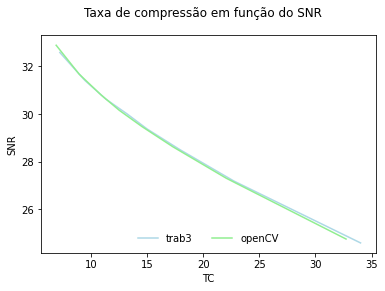

In [74]:
fig, ax = plt.subplots()
fig.suptitle('Taxa de compressão em função do SNR')
ax.plot(jpeg_TC, jpeg_SNR, 'lightblue', label='trab3')
ax.plot(openCV_TC, openCV_SNR, 'lightgreen', label='openCV')
ax.legend(frameon=False, loc='lower center', ncol=2);
# plot display settings
plt.xlabel('TC')
plt.ylabel('SNR')
plt.show()

<a id="tabelas"></a>

## Tabelas

Lena size in grayscale: 262 KB


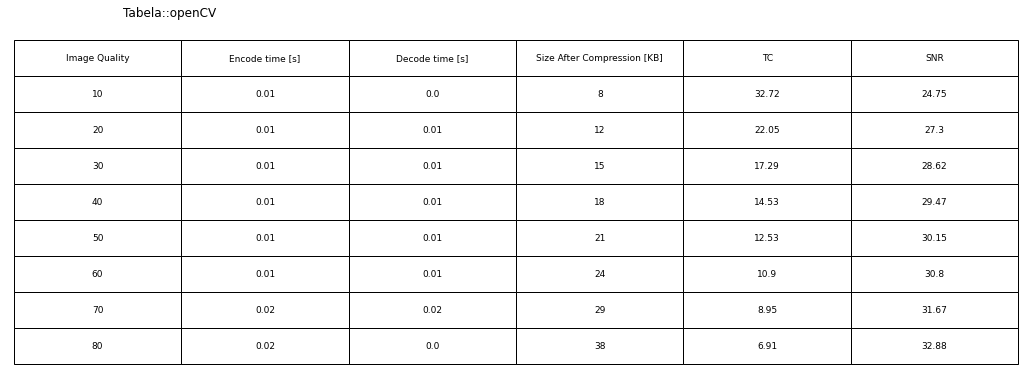

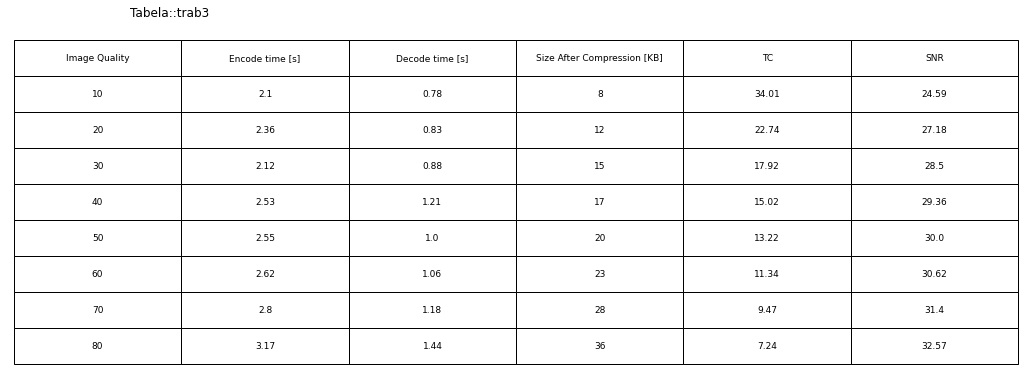

In [96]:
print(f"Lena size in grayscale: {int(lena_gray_size / 1000 +.5)} KB")

table_header = ['Image Quality', 'Encode time [s]','Decode time [s]', 'Size After Compression [KB]', 'TC', 'SNR']

openCV_table_data = []
for i in range(len(jpeg_quality)):
    openCV_table_data.append( 
        [jpeg_quality[i], 
         round(openCV_encode_time[i],2), 
         round(openCV_decode_time[i],2), 
         int(openCV_compression_size[i]/1000+.5),
         round(openCV_TC[i],2),
         round(openCV_SNR[i],2)]
    )

trab3_table_data = []
for i in range(len(jpeg_quality)):
    trab3_table_data.append( 
        [jpeg_quality[i], 
         round(jpeg_encode_time[i],2), 
         round(jpeg_decode_time[i],2), 
         int(jpeg_compression_size[i]/1000+.5),
         round(jpeg_TC[i],2),
         round(jpeg_SNR[i],2)]
    )
    
# create tables
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()

# hide the axes
fig.patch.set_visible(False)
ax1.axis('off')
ax1.axis('tight')
ax2.axis('off')
ax2.axis('tight')

# build tables
openCV_table = ax1.table(
    cellText=openCV_table_data, 
    colLabels=table_header, 
    cellLoc='center',
    loc ='upper left')

trab3_table = ax2.table(
    cellText=trab3_table_data, 
    colLabels=table_header, 
    cellLoc='center',
    loc ='upper left')

# display tables
fig1.suptitle('Tabela::openCV')
openCV_table.scale(3,3)
fig2.suptitle('Tabela::trab3')
trab3_table.scale(3,3)

plt.show()


[back to index](#index)

 <a id="conclusoes"></a>

# Conclusões

O presente trabalho prático, teve como objetivo explora os princípios básicos da norma JPEG (modo sequencial) para compressão de imagens com perdas.

Na compressão JPEG realizada neste trabalho, existe efetivamente compactação com perdas de forma irreversível da imagem original. Contudo foram utilizadas técnicas onde a informação descartada é feita de tal forma onde o nível de degradação é pouco significativo, e o utilizador final pode mesmo nem reparar que tal degradação acontece, isto porque a informação descartada corresponde a informação de alta, que o ser ser humano não consegue observar com clareza quando existes mudanças neste espectro.

As funções **divide_blocks** e **merge_blocks** estão preparadas para receber imagens grayscale e rgb de qualquer dimensão, acrescentado em caso de falta, pixels com valores 0 para colmatar a falta de pixels da imagem para criar blocos de 8x8. 

Em caso da imagem ser RGB é feita ainda a conversão para o espaço de cores YUV. Contudo no contexto deste trabalho não tem nenhuma importância, uma vez que para efeitos académicos, apenas se a trabalhar com a tabela da luminância para realizar a codificação de Huffman, ficando assim em falta a codificação para a tabela da crominância que é necessária para quando se trabalha com imagens com mais do que uma banda.

Para efeitos de teste realizou-se para diferentes factores de qualidade, a conversão jpeg para a imagem Lena no espaço de cores de cinza. Para cada qualidade foi medida a relação sinal-ruído e a taxa de compressão obtida, utilizando o algorítmo desenvolvido neste trabalho prático e com o openCV.

O [gráfico](#grafico) representa a taxa de compressão em função do SNR utilizando os dois algorítmos atrás mencionados. É possível constatar após análise que ambos tem um comportamento idêntico, onde à medida que o fator de qualidade aumenta a taxa de compressão vai sendo cada vez menor mas em contrapartida resultará numa imagem com melhor qualidade (onde neste caso qualidade entende-se quanto mais parecida for com a imagem original.

As [tabelas](#tabelas) mostram todos os resultados da SNR, taxa de compressão, tempo de compressão e descompressão. Como seria de esperar após análise do [gráfico](#grafico) anterior, os valores da TC e da SNR em ambas as tabelas são muito idênticos. Apesar do algorítmo realizado no presente trabalho 3, apresentar valores melhores de compressão quando comparado com os obtidos usando o openCV, é preciso desmitificar o caso, pois no caso do openCV a imagem é guardada em formato jpeg e tem no seu cabeçalho a informação das tabelas de Huffman para luminância e crominância, enquanto no algorítmo desenvolvido essa informação não esta presente no header, porque subtende-se que se estão a usar os valores das [Tabelas da norma ITU T.81 - JPEG standard](#ITU_T.81).

Observando os tempos de codificação e descodificação para a imagem Lena, repara-se que o tempo de execução da operação vai ficando linearmente mais lento à medida que o fator de qualidade aumenta. Isto acontece pois existem menos zeros gerados pela operação da DCT e Quantitização, resultando em mais valores onde é necessário aplicar a codificação de Huffman.

Onde o algorítmo desenvolvido peca indiscutivelmente quando comparado com o openCV é efetivamente nos tempos de execução, sendo entre cerca de 100 x mais lento. Neste aspeto posso apenas especular que o openCV utiliza operações lógicas bit a bit para realizar as operações bem como tirará partido das operações matriciais que o numpy terá para oferecer, enquando no algorítmo desenvolvido a codificação e a descoficação são conseguidas através de iterações sequênciais com recurso à manipulação de strings que são consideravelmente mais lentas.

No final considera-se que todos os ojetivos pedidos no enunciado foram cumpridos com sucesso.

[back to index](#index)